# Library Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Import Datasets

In [ ]:
train_csv_url = "/content/drive/MyDrive/#Semester07/CS4622/ML Project/speech-based-classification-layer-9/train.csv"
valid_csv_url = "/content/drive/MyDrive/#Semester07/CS4622/ML Project/speech-based-classification-layer-9/valid.csv"
test_csv_url = "/content/drive/MyDrive/#Semester07/CS4622/ML Project/speech-based-classification-layer-9/test.csv"

train_data = pd.read_csv(train_csv_url)
valid_data = pd.read_csv(valid_csv_url)
test_data = pd.read_csv(test_csv_url)

print("Train data:")
print(train_data.head())
print("Valid data:")
print(valid_data.head())
print("Test data:")
print(test_data.head())

Train data:
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0   0.019301   0.059756   0.081375   0.057481  -0.068440  -0.165913   
1   0.049741   0.090030   0.035118  -0.013676  -0.194317  -0.101763   
2   0.019212   0.087779   0.093907  -0.033738  -0.141409  -0.062881   
3   0.070283   0.049040   0.042126   0.122637  -0.056964  -0.113700   
4   0.028864   0.165634   0.016302   0.036117  -0.028871  -0.147748   

   feature_7  feature_8  feature_9  feature_10  ...  feature_763  feature_764  \
0   0.035643  -0.091138   0.021688    0.057158  ...    -0.035576     0.127319   
1   0.085875  -0.081317   0.112418    0.120523  ...     0.020538     0.058968   
2  -0.071402  -0.006599   0.020372   -0.027777  ...     0.119645    -0.040861   
3   0.108454   0.051336   0.086610    0.141578  ...    -0.124494    -0.169225   
4   0.053180   0.025071  -0.004200   -0.022183  ...    -0.124862     0.044907   

   feature_765  feature_766  feature_767  feature_768  label_1  label_2  \

# Data Visualization

In [ ]:
def visualize_label(y, title, x_title, y_title='Number of entries'):
  unique_classes, class_counts = np.unique(y, return_counts=True)
  plt.bar(unique_classes, class_counts)
  plt.xlabel(x_title)
  plt.ylabel(y_title)
  plt.title(title)
  plt.show()

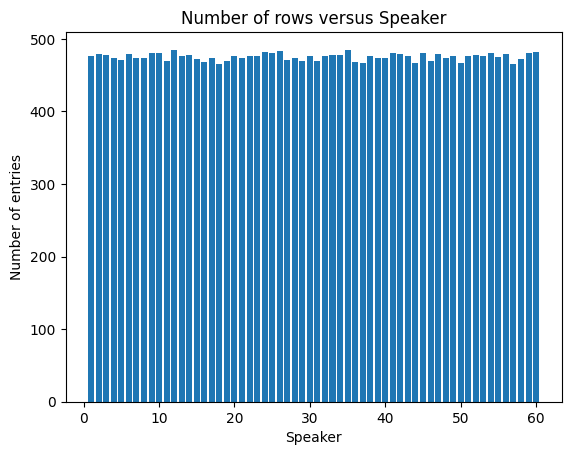

In [ ]:
visualize_label(train_data['label_1'], "Number of rows versus Speaker","Speaker")

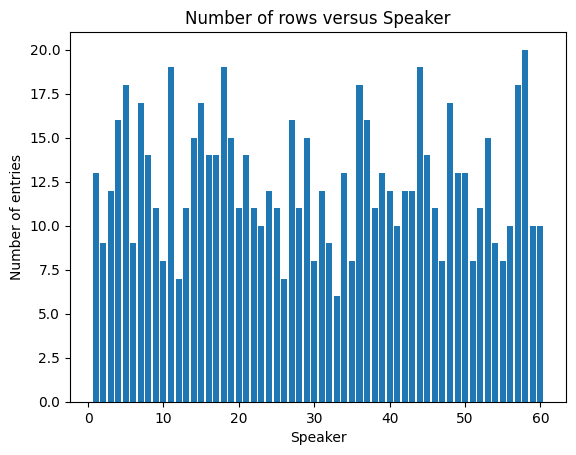

In [ ]:
visualize_label(valid_data['label_1'], "Number of rows versus Speaker","Speaker")

# Outlier Detection and Removal

In [ ]:
from scipy.stats import norm

def visualize_label_norm(y, title, x_title, y_title='Number of entries'):
  unique_classes, class_counts = np.unique(y, return_counts=True)
  plt.bar(unique_classes, class_counts)
  plt.xlabel(x_title)
  plt.ylabel(y_title)
  plt.title(title)

  rng = np.arange(train_data["label_1"].min(), train_data["label_1"].max(), 0.1)
  plt.plot(rng, norm.pdf(rng,train_data["label_1"].mean(),train_data["label_1"].std()))
  plt.show()

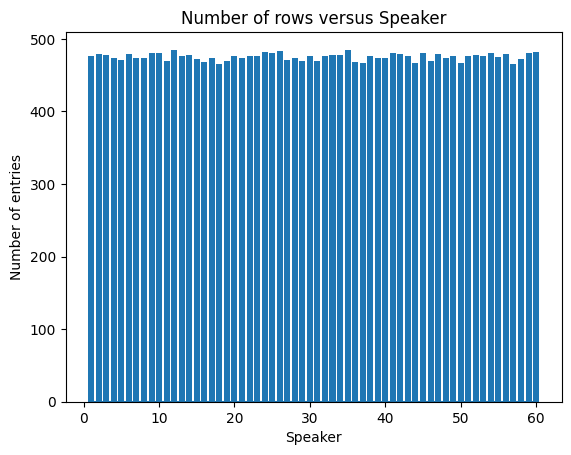

In [ ]:
visualize_label_norm(train_data['label_1'], "Number of rows versus Speaker","Speaker")

In [ ]:
train_data['zscore'] = ( train_data["label_1"] - train_data["label_1"].mean() ) / train_data["label_1"].std()
outliers = train_data[(train_data.zscore<-3) | (train_data.zscore>3)]
outliers.shape

(0, 773)

No outliers to remove

# Train without Feaure Reduction

In [ ]:
print(f"train_data dataset shape {train_data.shape}")
print(f"# of missing values {train_data['label_1'].isna().sum()}")
print(f"# of labels {train_data['label_1'].value_counts().shape[0]}")
print(f"label summary\n{train_data['label_1'].value_counts()}")

train_data dataset shape (28520, 773)
# of missing values 0
# of labels 60
label summary
12    485
35    484
26    483
60    482
24    482
25    481
59    481
10    481
54    481
45    480
41    480
9     480
2     479
42    479
47    479
6     479
56    479
34    478
52    478
3     478
14    478
33    478
43    477
1     477
13    477
20    477
23    477
30    476
51    476
32    476
53    476
22    476
38    476
49    476
55    475
28    474
8     474
40    474
48    474
21    474
4     474
39    473
17    473
7     473
15    472
58    472
5     471
27    471
31    470
19    469
11    469
46    469
29    469
36    468
16    468
50    467
37    467
44    467
57    466
18    465
Name: label_1, dtype: int64


Feature Enginering

*   Label_1 has no missing values
*   Label_1 has 60 unique classes
*   Using one-hot encoding for multilabel classification



In [ ]:
label_1 = train_data['label_1'].values.reshape(-1, 1)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(label_1)
print(ohe.categories_)

label_1 = ohe.transform(label_1)
print(label_1)

[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60])]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data.iloc[:, :768], label_1, test_size=0.2, stratify=label_1, random_state=2023)

In [ ]:
X_train_tensors = torch.tensor(X_train.iloc[:, :].values, dtype=torch.float32)
print(X_train_tensors.shape)

X_test_tensors = torch.tensor(X_test.iloc[:, :].values, dtype=torch.float32)
print(X_test_tensors.shape)

torch.Size([22816, 768])
torch.Size([5704, 768])


## Define the Model

In [ ]:
class SpeakerClassifier(nn.Module):
    def __init__(self, dropout_prob=0.5, weight_decay=1e-5):
        super(SpeakerClassifier, self).__init__()
        self.linear1 = nn.Linear(768, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 60)

        # Set weight_decay for regularization
        self.weight_decay = weight_decay

    def forward(self, tensors):
        output_l1 = torch.relu(self.linear1(tensors))
        output_l2 = torch.relu(self.linear2(output_l1))
        output_l3 = torch.relu(self.linear3(output_l2))
        output_l4 = self.linear4(output_l3)
        return output_l4

    def l2_regularization_loss(self):
        # Calculate L2 regularization loss for linear layers
        l2_loss = 0.0
        for param in self.parameters():
            if param.requires_grad:
                l2_loss += torch.norm(param, 2)
        return self.weight_decay * l2_loss

## Train the model

In [ ]:
# Create an instance of the SpeakerClassifier model
speakerClassifier = SpeakerClassifier()

# Define a cross-entropy loss function
criterion = nn.CrossEntropyLoss()

# Create a DataLoader for batching
batch_size = 128
dataset = TensorDataset(X_train_tensors, torch.tensor(y_train))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define an optimizer
optimizer = torch.optim.Adam(speakerClassifier.parameters(), lr=0.001)

# Define early stopping parameters
patience = 25
best_validation_accuracy = 0
no_improvement_counter = 0

# Training loop
epochs = 1000
for epoch in range(epochs):

    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = speakerClassifier(inputs)

        ce_loss = criterion(outputs, targets)
        l2_loss = speakerClassifier.l2_regularization_loss()

        total_loss = ce_loss + l2_loss

        total_loss.backward()
        optimizer.step()

    # Validation step (evaluate on validation dataset)
    with torch.no_grad():
        speakerClassifier.eval()
        y_test_pred = speakerClassifier(X_test_tensors)
        ce = criterion(y_test_pred, torch.tensor(y_test))
        acc = (torch.argmax(y_test_pred, 1) == torch.argmax(torch.tensor(y_test), 1)).float().mean()
        speakerClassifier.train()

    print(f"Epoch {epoch} validation: Cross-entropy={float(ce)}, Accuracy={float(acc)}")

    # Check for early stopping
    if acc > best_validation_accuracy:
        best_validation_accuracy = acc
        no_improvement_counter = 0
        # Save the trained best model if needed
        torch.save(speakerClassifier.state_dict(), 'speakerClassifier_model.pth')
    else:
        no_improvement_counter += 1

    # If no improvement for 'patience' consecutive epochs, stop training
    if no_improvement_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

Epoch 0 validation: Cross-entropy=1.5559583832142445, Accuracy=0.5149018168449402
Epoch 1 validation: Cross-entropy=1.028779309649143, Accuracy=0.6747896075248718
Epoch 2 validation: Cross-entropy=0.7935166183119098, Accuracy=0.7561360597610474
Epoch 3 validation: Cross-entropy=0.7310103976003122, Accuracy=0.7750701308250427
Epoch 4 validation: Cross-entropy=0.6018022183022717, Accuracy=0.8152173757553101
Epoch 5 validation: Cross-entropy=0.5412748272518629, Accuracy=0.8383590579032898
Epoch 6 validation: Cross-entropy=0.5059897907156717, Accuracy=0.8471248149871826
Epoch 7 validation: Cross-entropy=0.44440469821410267, Accuracy=0.8676367402076721
Epoch 8 validation: Cross-entropy=0.4736964025988395, Accuracy=0.8620266318321228
Epoch 9 validation: Cross-entropy=0.43468078131774285, Accuracy=0.8676367402076721
Epoch 10 validation: Cross-entropy=0.3837178790843041, Accuracy=0.8876227140426636
Epoch 11 validation: Cross-entropy=0.36510674829818257, Accuracy=0.8902524709701538
Epoch 12 val

In [12]:
# Create an instance of the model
speakerClassifier = SpeakerClassifier()

# Load the saved model state dictionary
speakerClassifier.load_state_dict(torch.load('/content/drive/Shareddrives/test/ML _Project/speakerClassifier_model.pth'))

# Validation step (evaluate on validation dataset)
with torch.no_grad():
    speakerClassifier.eval()
    y_test_pred = speakerClassifier(X_test_tensors)
    ce = criterion(y_test_pred, torch.tensor(y_test))
    acc = (torch.argmax(y_test_pred, 1) == torch.argmax(torch.tensor(y_test), 1)).float().mean()

print(f"Best model validation: Cross-entropy={float(ce)}, Accuracy={float(acc)}")

Best model validation: Cross-entropy=0.33610116394825557, Accuracy=0.9556451439857483


## Evaluation of the Model

In [ ]:
label_1_eval = valid_data['label_1'].values.reshape(-1, 1)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(label_1_eval)
print(ohe.categories_)

label_1_eval = ohe.transform(label_1_eval)
print(label_1_eval)

[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60])]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Set your model to evaluation mode
speakerClassifier.eval()

X_valid_tensors = torch.tensor(valid_data.iloc[:, :768].values, dtype=torch.float32)
print(X_valid_tensors.shape)

y_pred = speakerClassifier(X_valid_tensors)
ce = criterion(y_pred, torch.tensor(label_1_eval))
acc = (torch.argmax(y_pred, 1) == torch.argmax(torch.tensor(label_1_eval), 1)).float().mean()
print(f"Cross-entropy={float(ce)}, Test Accuracy={float(acc)}")

torch.Size([750, 768])
Cross-entropy=0.288925059106326, Test Accuracy=0.9573333263397217


In [ ]:
y_pred_labels = torch.argmax(y_pred, axis=1).numpy()
label_1_np = torch.argmax(torch.tensor(label_1_eval), axis=1).numpy()

confusion = confusion_matrix(label_1_np, y_pred_labels)
print(classification_report(label_1_np, y_pred_labels))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       1.00      1.00      1.00         9
           2       0.92      1.00      0.96        12
           3       0.94      1.00      0.97        16
           4       1.00      1.00      1.00        18
           5       1.00      0.89      0.94         9
           6       0.94      0.94      0.94        17
           7       1.00      0.79      0.88        14
           8       1.00      0.91      0.95        11
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00        19
          11       1.00      1.00      1.00         7
          12       1.00      0.91      0.95        11
          13       0.93      0.93      0.93        15
          14       0.88      0.88      0.88        17
          15       1.00      1.00      1.00        14
          16       1.00      1.00      1.00        14
          17       1.00    

In [ ]:
accuracy_score(label_1_np, y_pred_labels)

0.9573333333333334

## Get Test

In [ ]:
label_1_t = test_data['label_1'].values.reshape(-1, 1)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(label_1_t)
print(ohe.categories_)

label_1_t = ohe.transform(label_1_t)
print(label_1_t)

[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60])]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Set your model to evaluation mode
speakerClassifier.eval()

X_t_tensors = torch.tensor(test_data.iloc[:, :768].values, dtype=torch.float32)
print(X_t_tensors.shape)

y_pred_t = speakerClassifier(X_t_tensors)
ce = criterion(y_pred_t, torch.tensor(label_1_t))
acc = (torch.argmax(y_pred_t, 1) == torch.argmax(torch.tensor(label_1_t), 1)).float().mean()
print(f"Cross-entropy={float(ce)}, Test Accuracy={float(acc)}")

torch.Size([28520, 768])
Cross-entropy=0.0672247032907527, Test Accuracy=0.9911290407180786


In [ ]:
y_pred_t_labels = torch.argmax(y_pred_t, axis=1).numpy()
label_1_np_t = torch.argmax(torch.tensor(label_1_t), axis=1).numpy()

confusion = confusion_matrix(label_1_np_t, y_pred_t_labels)
print(classification_report(label_1_np_t, y_pred_t_labels))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       477
           1       0.99      0.99      0.99       479
           2       0.99      0.99      0.99       478
           3       0.99      0.99      0.99       474
           4       0.99      0.99      0.99       471
           5       1.00      1.00      1.00       479
           6       0.99      0.99      0.99       473
           7       0.98      0.99      0.99       474
           8       1.00      1.00      1.00       480
           9       1.00      1.00      1.00       481
          10       0.99      1.00      0.99       469
          11       0.99      1.00      1.00       485
          12       0.99      1.00      0.99       477
          13       0.99      0.99      0.99       478
          14       0.99      0.99      0.99       472
          15       1.00      0.99      1.00       468
          16       1.00      0.99      0.99       473
          17       0.99    

In [ ]:
accuracy_score(label_1_np_t, y_pred_t_labels)

0.9911290322580645

# Train with Feature Engineering

In [ ]:
data_features = train_data.iloc[:, :768]

## Drop Constant Features Using Variance Threshold

In [ ]:
var_thres=VarianceThreshold(threshold=0)
var_thres.fit(data_features)

VarianceThreshold(threshold=0)

In [ ]:
constant_columns = [column for column in data_features.columns
                    if column not in data_features.columns[var_thres.get_support()]]

print(constant_columns)

[]


There is no constant columns

## Drop Features Using Pearson Correlation

In [ ]:
data_features.corr()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768
feature_1,1.000000,0.065348,-0.039416,0.116528,0.108225,-0.163679,0.131004,-0.073198,-0.045476,-0.120560,...,-0.225724,0.290177,0.015310,0.144664,-0.110313,-0.040330,0.132620,0.032706,0.035296,-0.039317
feature_2,0.065348,1.000000,0.043611,0.068624,-0.278709,0.052155,-0.267946,-0.214403,-0.235840,-0.056829,...,-0.150852,-0.096604,0.287950,-0.099087,0.269144,0.005612,-0.068710,-0.204834,-0.350866,0.162593
feature_3,-0.039416,0.043611,1.000000,-0.185437,-0.313107,-0.103496,-0.214606,-0.185952,0.155197,0.011407,...,-0.248988,-0.162378,-0.024814,0.162806,0.231606,0.204807,0.133835,-0.063354,0.159975,0.217143
feature_4,0.116528,0.068624,-0.185437,1.000000,0.096349,-0.220416,0.194002,0.027816,-0.144393,-0.148927,...,0.135598,0.071113,-0.084978,-0.166751,-0.220446,0.103712,0.100221,0.006758,0.034292,-0.128138
feature_5,0.108225,-0.278709,-0.313107,0.096349,1.000000,0.021056,0.325761,-0.000900,0.038333,-0.116997,...,-0.020572,0.024932,-0.202849,0.031865,-0.371326,-0.087327,-0.063512,0.016875,-0.031415,-0.203071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature_764,-0.040330,0.005612,0.204807,0.103712,-0.087327,-0.174192,0.122454,0.012446,0.199985,0.171440,...,0.075743,0.065512,-0.313912,-0.196618,-0.114188,1.000000,0.208730,0.181622,0.405485,-0.009266
feature_765,0.132620,-0.068710,0.133835,0.100221,-0.063512,-0.345465,-0.002038,0.005804,0.053829,-0.116723,...,-0.103060,0.180543,-0.010908,-0.076788,0.228983,0.208730,1.000000,-0.204636,0.278358,-0.172730
feature_766,0.032706,-0.204834,-0.063354,0.006758,0.016875,-0.233690,0.282928,-0.105139,0.097498,0.391228,...,0.096985,0.293527,-0.266795,0.168379,-0.486373,0.181622,-0.204636,1.000000,0.388446,-0.065182
feature_767,0.035296,-0.350866,0.159975,0.034292,-0.031415,-0.350340,0.185927,0.045446,0.113304,0.265687,...,0.115303,0.274362,-0.343106,0.081103,-0.327079,0.405485,0.278358,0.388446,1.000000,-0.132940


In [ ]:
# Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = data_features.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [ ]:
def correlation(dataset, threshold):
    correlated_pairs = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                rowname = corr_matrix.index[j]  # getting the name of row
                correlated_pairs.add((rowname, colname))
    return correlated_pairs

def get_less_correlated_features(correlated_pairs, dataset, target_column):
    less_correlated_features = {}

    for (feature1, feature2) in correlated_pairs:
        corr1 = dataset[feature1].corr(dataset[target_column])
        corr2 = dataset[feature2].corr(dataset[target_column])

        if abs(corr1) < abs(corr2):
            correlated_pair = frozenset((feature1, feature2))  # Use a frozenset as the key
            less_correlated_features[correlated_pair] = feature1
        else:
            correlated_pair = frozenset((feature1, feature2))  # Use a frozenset as the key
            less_correlated_features[correlated_pair] = feature2

    return less_correlated_features

In [ ]:
corr_feature_pairs = correlation(data_features, 0.9)
corr_feature_pairs

{('feature_210', 'feature_609')}

In [ ]:
less_correlated_features = get_less_correlated_features(corr_feature_pairs, train_data, "label_1")
less_correlated_features

{frozenset({'feature_210', 'feature_609'}): 'feature_210'}

In [ ]:
corr_features = set(less_correlated_features.values())
corr_features

{'feature_210'}

In [ ]:
new_features = data_features.drop(corr_features,axis=1)

In [ ]:
print(data_features.shape)
print(new_features.shape)

(28520, 768)
(28520, 767)


## Train the model

In [ ]:
class SpeakerClassifierAfter(nn.Module):
    def __init__(self, dropout_prob=0.5, weight_decay=1e-5):
        super(SpeakerClassifierAfter, self).__init__()
        self.linear1 = nn.Linear(767, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 60)

        # Set weight_decay for regularization
        self.weight_decay = weight_decay

    def forward(self, tensors):
        output_l1 = torch.relu(self.linear1(tensors))
        output_l2 = torch.relu(self.linear2(output_l1))
        output_l3 = torch.relu(self.linear3(output_l2))
        output_l4 = self.linear4(output_l3)
        return output_l4

    def l2_regularization_loss(self):
        # Calculate L2 regularization loss for linear layers
        l2_loss = 0.0
        for param in self.parameters():
            if param.requires_grad:
                l2_loss += torch.norm(param, 2)
        return self.weight_decay * l2_loss

In [ ]:
label_1 = train_data['label_1'].values.reshape(-1, 1)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(label_1)
print(ohe.categories_)

label_1 = ohe.transform(label_1)
print(label_1)

[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60])]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
X_train_after, X_test_after, y_train_after, y_test_after = train_test_split(new_features, label_1, test_size=0.2, stratify=label_1, random_state=2023)

X_train_tensors_after = torch.tensor(X_train_after.values, dtype=torch.float32)
print(X_train_tensors_after.shape)


X_test_tensors_after = torch.tensor(X_test_after.values, dtype=torch.float32)
print(X_test_tensors_after.shape)

torch.Size([22816, 767])
torch.Size([5704, 767])


In [ ]:
y_train_after.shape

(22816, 60)

In [ ]:
# Create an instance of the SpeakerClassifierAfter model
speakerClassifierAfter = SpeakerClassifierAfter()

# Define a cross-entropy loss function
criterion = nn.CrossEntropyLoss()

# Create a DataLoader for batching
batch_size = 128
dataset = TensorDataset(X_train_tensors_after, torch.tensor(y_train_after))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define an optimizer
optimizer = torch.optim.Adam(speakerClassifierAfter.parameters(), lr=0.001)

# Define early stopping parameters
patience = 25
best_validation_accuracy = 0
no_improvement_counter = 0

# Training loop
epochs = 1000
for epoch in range(epochs):

    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = speakerClassifierAfter(inputs)

        ce_loss = criterion(outputs, targets)
        l2_loss = speakerClassifierAfter.l2_regularization_loss()

        total_loss = ce_loss + l2_loss

        total_loss.backward()
        optimizer.step()

    # Validation step (evaluate on validation dataset)
    with torch.no_grad():
        speakerClassifierAfter.eval()
        y_test_pred_after = speakerClassifierAfter(X_test_tensors_after)
        ce = criterion(y_test_pred_after, torch.tensor(y_test_after))
        acc = (torch.argmax(y_test_pred_after, 1) == torch.argmax(torch.tensor(y_test_after), 1)).float().mean()
        speakerClassifierAfter.train()

    print(f"Epoch {epoch} validation: Cross-entropy={float(ce)}, Accuracy={float(acc)}")

    # Check for early stopping
    if acc > best_validation_accuracy:
        best_validation_accuracy = acc
        no_improvement_counter = 0
        # Save the trained best model if needed
        torch.save(speakerClassifierAfter.state_dict(), 'speakerClassifierAfter_model.pth')
    else:
        no_improvement_counter += 1

    # If no improvement for 'patience' consecutive epochs, stop training
    if no_improvement_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

Epoch 0 validation: Cross-entropy=1.6147941280695837, Accuracy=0.5042075514793396
Epoch 1 validation: Cross-entropy=1.0230065938041413, Accuracy=0.6818022727966309
Epoch 2 validation: Cross-entropy=0.8253696278778291, Accuracy=0.739656388759613
Epoch 3 validation: Cross-entropy=0.6631468157329805, Accuracy=0.799964964389801
Epoch 4 validation: Cross-entropy=0.6138733464962771, Accuracy=0.8125876784324646
Epoch 5 validation: Cross-entropy=0.5024200666432707, Accuracy=0.85326087474823
Epoch 6 validation: Cross-entropy=0.5088972061485371, Accuracy=0.8499298691749573
Epoch 7 validation: Cross-entropy=0.4223104331997433, Accuracy=0.8797335028648376
Epoch 8 validation: Cross-entropy=0.38888791717624127, Accuracy=0.8816620111465454
Epoch 9 validation: Cross-entropy=0.4198197602824701, Accuracy=0.8737727999687195
Epoch 10 validation: Cross-entropy=0.37935624420687303, Accuracy=0.885343611240387
Epoch 11 validation: Cross-entropy=0.36185815648436725, Accuracy=0.8899018168449402
Epoch 12 validat

In [ ]:
# Create an instance of the model
speakerClassifierAfter = SpeakerClassifierAfter()

# Define a cross-entropy loss function
criterion = nn.CrossEntropyLoss()

# Load the saved model state dictionary
speakerClassifierAfter.load_state_dict(torch.load('/content/drive/Shareddrives/test/ML _Project/speakerClassifierAfter_model.pth'))

# Validation step (evaluate on validation dataset)
with torch.no_grad():
    speakerClassifierAfter.eval()
    y_test_after_pred = speakerClassifierAfter(X_test_tensors_after)
    ce = criterion(y_test_after_pred, torch.tensor(y_test_after))
    acc = (torch.argmax(y_test_after_pred, 1) == torch.argmax(torch.tensor(y_test_after), 1)).float().mean()

print(f"Best model validation: Cross-entropy={float(ce)}, Accuracy={float(acc)}")


Best model validation: Cross-entropy=0.3084395525612473, Accuracy=0.9460027813911438


## Evaluation of the Model

In [ ]:
label_1_eval = valid_data['label_1'].values.reshape(-1, 1)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(label_1_eval)
print(ohe.categories_)

label_1_eval = ohe.transform(label_1_eval)
print(label_1_eval)

[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60])]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Set your model to evaluation mode
speakerClassifierAfter.eval()

new_features_valid = valid_data.iloc[:, :768].drop(corr_features,axis=1)
X_valid_tensors_after = torch.tensor(new_features_valid.values, dtype=torch.float32)
print(X_valid_tensors_after.shape)

y_pred_valid_after = speakerClassifierAfter(X_valid_tensors_after)
ce = criterion(y_pred_valid_after, torch.tensor(label_1_eval))
acc = (torch.argmax(y_pred_valid_after, 1) == torch.argmax(torch.tensor(label_1_eval), 1)).float().mean()
print(f"Cross-entropy={float(ce)}, Test Accuracy={float(acc)}")

torch.Size([750, 767])
Cross-entropy=0.25500828965253247, Test Accuracy=0.9599999785423279


In [ ]:
y_pred_valid_after_labels = torch.argmax(y_pred_valid_after, axis=1).numpy()
label_1_np_valid_after = torch.argmax(torch.tensor(label_1_eval), axis=1).numpy()

confusion = confusion_matrix(label_1_np_valid_after, y_pred_valid_after_labels)
print(classification_report(label_1_np_valid_after, y_pred_valid_after_labels))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       1.00      1.00      1.00         9
           2       0.92      1.00      0.96        12
           3       0.93      0.88      0.90        16
           4       1.00      0.94      0.97        18
           5       1.00      0.89      0.94         9
           6       0.94      0.94      0.94        17
           7       0.93      1.00      0.97        14
           8       1.00      0.91      0.95        11
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00        19
          11       1.00      1.00      1.00         7
          12       1.00      0.91      0.95        11
          13       1.00      0.93      0.97        15
          14       0.89      0.94      0.91        17
          15       1.00      1.00      1.00        14
          16       0.93      0.93      0.93        14
          17       1.00    

In [ ]:
accuracy_score(label_1_np_valid_after, y_pred_valid_after_labels)

0.96

In [ ]:
y_pred_one_hots = ohe.inverse_transform(y_pred_valid_after.detach().numpy())
label_1_preds = pd.DataFrame(y_pred_one_hots, columns=['label_1_preds'])
label_1_preds = pd.concat([valid_data["label_1"], label_1_preds], axis=1)
label_1_preds

,label_1,label_1_preds
0,45,45
1,45,45
2,45,45
3,45,45
4,45,45
...,...,...
745,39,39
746,39,39
747,39,39
748,39,39


## Get Test Results

In [ ]:
# Set your model to evaluation mode
speakerClassifierAfter.eval()

new_features_test = test_data.iloc[:, :768].drop(corr_features,axis=1)
X_t_tensors_after = torch.tensor(new_features_test.values, dtype=torch.float32)
print(X_t_tensors_after.shape)

y_pred_t_after = speakerClassifierAfter(X_t_tensors_after)
print(y_pred_t_after.shape)

torch.Size([744, 767])
torch.Size([744, 60])


In [ ]:
y_pred_one_hot = ohe.inverse_transform(y_pred_t_after.detach().numpy())
test_data["label_1"] = pd.DataFrame(y_pred_one_hot, columns=["label_1"])

In [ ]:
test_data.head()

,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768,label_1
0,1,0.013112,0.130904,0.020284,0.063018,-0.034321,-0.073516,-0.030659,-0.064994,0.024153,...,0.241121,0.079949,-0.186099,-0.096718,0.126006,-0.023069,0.190374,0.146516,0.038047,15
1,2,0.005934,0.138592,-0.007000,0.055925,-0.021927,-0.084788,0.013339,0.060811,-0.011344,...,0.042921,0.018571,-0.114785,-0.105186,0.059050,0.021443,0.013027,0.046826,-0.026682,1
2,3,-0.067210,0.078710,-0.044344,0.101248,-0.074331,-0.088951,0.074616,0.007231,0.021091,...,0.053370,0.096232,-0.369018,-0.066708,-0.003730,-0.063339,-0.044497,-0.024363,-0.042594,16
3,4,-0.005678,0.060703,0.033954,0.068771,-0.039923,-0.186583,0.014921,0.020791,0.017441,...,0.018405,-0.018047,-0.080393,-0.114030,0.048255,0.033839,0.035026,-0.047988,-0.038252,12
4,5,-0.076360,0.061095,-0.004938,0.066692,-0.040454,-0.005141,-0.003213,0.025721,0.083558,...,0.045479,0.057146,-0.194466,0.000739,0.018702,0.013192,-0.038486,0.033358,-0.038452,16


In [ ]:
file_path = "/content/drive/MyDrive/#Semester07/CS4622/ML Project/speech-based-classification-layer-9/label_1.csv"

# Save the DataFrame to a CSV file
test_data.to_csv(file_path, index=False)